# Evaluation of Clusters

**CS5483 Data Warehousing and Data Mining**
$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}
$
___

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# produce vector inline graphics
from IPython.display import set_matplotlib_formats, Code
set_matplotlib_formats('svg')
from ipywidgets import interact
import ipywidgets as widgets
from scipy.optimize import linear_sum_assignment

In this notebook, we will consider different methods of evaluating clustering solutions.

## Intrinsic measure

The intrinsic measures of cluster quality is useful when the ground truth is not available or should not be used. For example, to determine the number of clusters, we can compare the intrinsic measures of the clustering solutions for different numbers of clusters.

### Elbow Method

To determine the number $k$ of clusters for a centroid-based clustering algorithm, the elbow method uses the within cluster sum of squared $\operatorname{WSS}(k)$ errors as the intrinsic quality measure. Instead of minimizing $\operatorname{WSS}(k)$, it maximizes the marginal decrease. 

The following diagram shows the KnowledgeFlow interface of Weka that applies `SimpleKMeans` to the `iris.2D.arff` dataset for different choices of $k$.

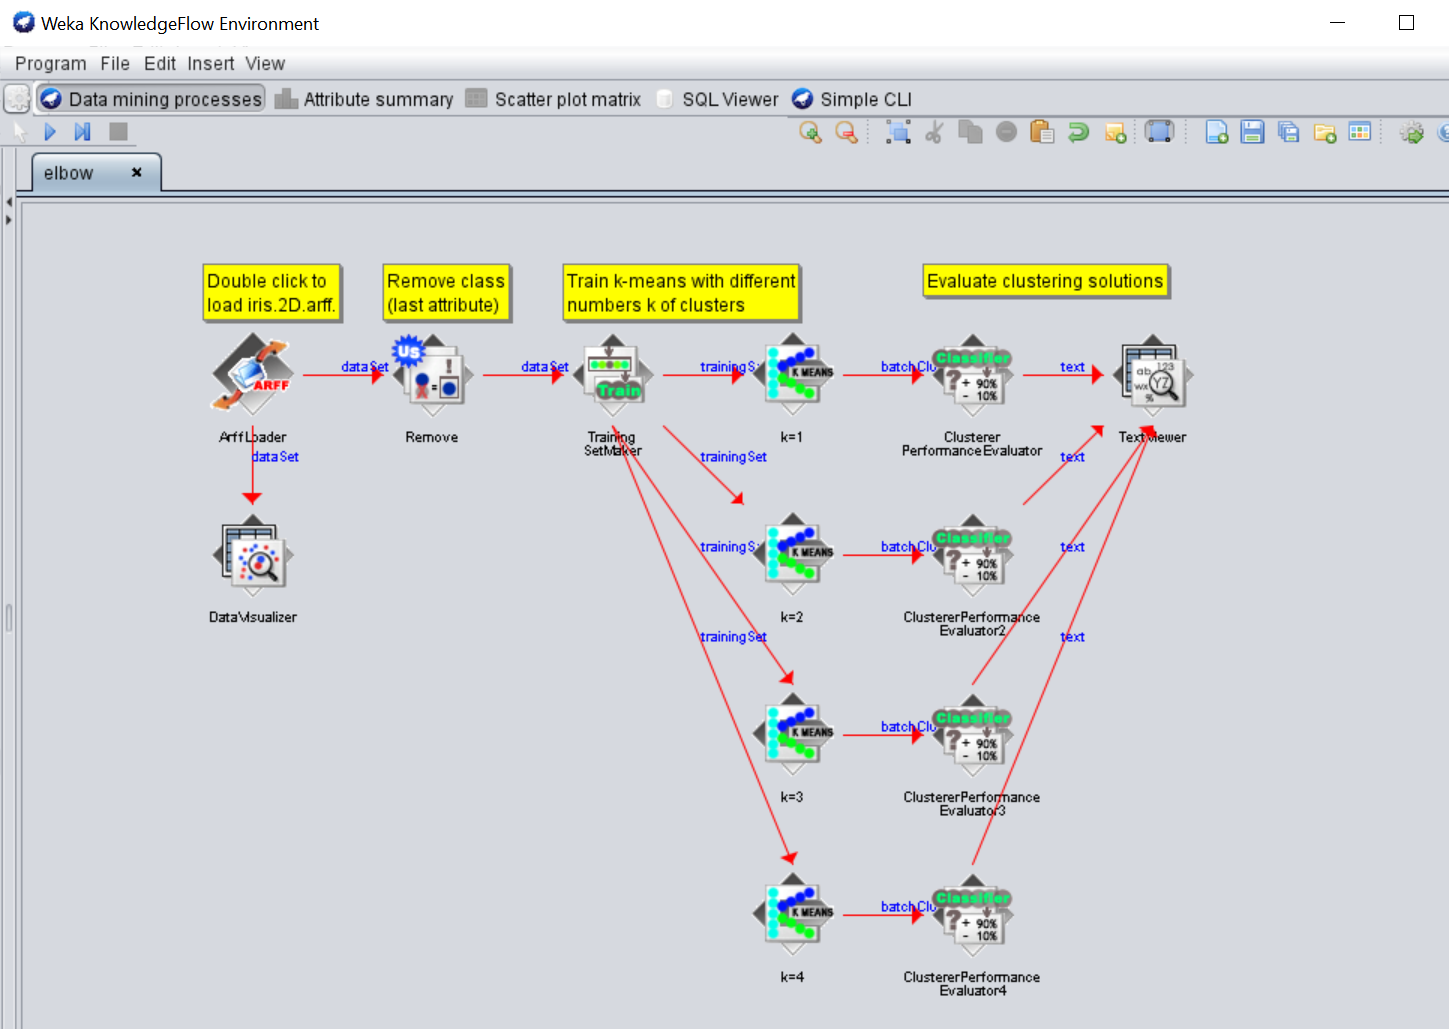

Implement the above using Weka. As the following video shows, it is now possible to run Weka GUI in a web browser through the JupyterHub server:

In [2]:
IFrame(src="https://cityuhk-lms.ap.panopto.com/Panopto/Pages/Embed.aspx?id=e38e4edb-816e-4535-b0d2-acf40085c0e4&autoplay=false&offerviewer=true&showtitle=true&showbrand=false&start=0&interactivity=all", height=450, width=805)

NameError: name 'IFrame' is not defined

- Under the `Files` tab, click the `new` button on the right and choose `xpra desktop`.
- In the terminal, run the command `weka-stable-gui` to launch Weka. 

To access the weka data files under your home directory as `~/wekadata`, execute the following cell, which creates a symbolic link to the data folder:

In [ ]:
if input('Create symlink to weka data file? [Y/n]').lower() != 'n':
    !ln -s /home/course/cs5483/wekadata ~/

**Exercise** Complete the following `DataFrame` `df_WSS` by recording $\operatorname{WSS}(k)$ for $k$ from 1 to 4. Your answer may look like

```Python
...
df_WSS['WSS'] = [__, __, __, __]
...
```

In [ ]:
df_WSS = pd.DataFrame(columns=['k', 'WSS'])
df_WSS['k'] = np.arange(1, 5, dtype=int)
df_WSS['WSS'] = df_WSS['WSS'].astype(float)
# YOUR CODE HERE
raise NotImplementedError()

# plot WSS as a function of k
df_WSS.plot(x='k', y='WSS')
plt.xlabel('k')
plt.ylabel('WSS')
plt.show()
df_WSS

In [ ]:
# tests

### Silouette analysis

An alternative method to the elbow method is the silouette analysis. We will use the existing implementation in `sklearn`. First, import the iris dataset from `sklearn.datasets` and store it as a `DataFrame`:

In [ ]:
# load the dataset from sklearn
dataset = datasets.load_iris()

# create a DataFrame to help further analysis
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target
df.target = df.target.astype('category')
df.target.cat.categories = dataset.target_names
df  # display an overview of the data

To cluster the data using $k$-means clustering:

In [ ]:
from sklearn.cluster import KMeans

kmeans_minmax_normalized = make_pipeline(preprocessing.MinMaxScaler(),
                                         KMeans(n_clusters=3, random_state=0))
kmeans_minmax_normalized

feature1, feature2 = 'petal length (cm)', 'petal width (cm)'
labels = kmeans_minmax_normalized.fit_predict(df[[feature1, feature2]])

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(df[feature1], df[feature2], c=labels)
plt.title("Cluster assignment")
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.subplot(122)
plt.scatter(df[feature1], df[feature2], c=dataset['target'])
plt.title("Class (ground truth)")
plt.xlabel(feature1)

plt.show()

**Exercise** Complete the following `DataFrame` `df_silouette` by recording the [`silouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for different number $k$ of clusters from 2 to 10. Your answer may look like

```Python
        ...
        df_silouette.loc[i, 's'] = silhouette_score(___, ___)
        ...
```
A more elaborate silhouette analysis is given [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py).

In [ ]:
from sklearn.metrics import silhouette_score

df_silouette = pd.DataFrame(columns=['k', 's'])
df_silouette['k'] = np.arange(2, 11, dtype=int)
df_silouette['s'] = df_silouette['s'].astype(float)
for i in range(len(df_silouette)):
    labels_ = make_pipeline(
        preprocessing.MinMaxScaler(),
        KMeans(n_clusters=df_silouette.loc[i, 'k'],
               random_state=0)).fit_predict(df[[feature1, feature2]])
    # YOUR CODE HERE
    raise NotImplementedError()
    
# plot WSS as a function of k
df_silouette.plot(x='k', y='s')
plt.xlabel('k')
plt.ylabel('silouette score')
plt.show()
df_silouette

In [ ]:
# tests

### Extrinsic measures of cluster quality

Suppose $L(\M{p})$ and $C(\M{p})$ are the class and cluster labels of each sample $\M{p}\in D$. An extrinsic measure compares how similar the corresponding partitions $\Set{L_i}$ and $\Set{C_i}$ are, where

\begin{align}
L_i &:=\Set{\M{p}|L(\M{p})=i}\\
C_i &:=\Set{\M{p}|C(\M{p})=i}.
\end{align}

#### Pairwise correctness

Define the indicator of correct clustering for a pair $\M{p}, \M{q}\in D$ as

\begin{align}
\op{correctness}(\M{p},\M{q}) := 
\begin{cases}
1 & L(\M{p})=L(\M{q}) \iff C(\M{p})=C(\M{q})\\
0 & \text{otherwise.}
\end{cases}
\end{align}

In other words, the clustering for the pair of samples is correct when 
- the samples have equal class labels and equal cluster labels, or
- the samples have different class labels and different cluster labels.

The following function returns a boolean matrix of $[\op{correctness}(\M{p},\M{q})]$, with rows an columns indexed by $\M{p}$ and $\M{q}$ respectively.

In [ ]:
def correctness(class_labels, cluster_labels):
    '''Returns the pairwise correctness matrix for the class and cluster labels.
    
    Parameters:
    -----------
    class_labels (array): non-negative integer class labels for certain samples
    cluster_labels (array): corresponding non-negative integer cluster labels
    
    Returns:
    --------
    A matrix (2D array) of correctness(p,q) with rows and columns indexed by 
    p and q respectively in the samples. correctness(p,q) indicates whether
      - p and q have equal class labels and equal cluster labels, or
      - p and q have different class labels and different cluster labels.
    '''
    class_labels = np.asarray(class_labels)
    cluster_labels = np.asarray(cluster_labels)

    eq_class = class_labels.reshape(-1, 1) == class_labels.reshape(1, -1)
    eq_cluster = cluster_labels.reshape(-1, 1) == cluster_labels.reshape(1, -1)

    return (eq_class & eq_cluster) | ~(eq_class | eq_cluster)

For instance, consider the following class and cluster labels:

|index $i$|class label $L(\M{p}_i)$ | cluster label $C(\M{p}_i)$|
|:-:|:----------:|:----------:|
| 0 | 0 | 1 |
| 1 | 0 | 1 |
| 2 | 1 | 0 |

The correctness matrix and the fraction correctly clustered pairs are:

In [ ]:
correctness_matrix = correctness(class_labels=[0, 0, 1],
                                 cluster_labels=[1, 1, 0])
correctness_accuracy = correctness_matrix.mean()
print(f'Correctness matrix:\n {correctness_matrix}')
print(f'Accuracy: {correctness_matrix.mean():.3g}')

**Exercise** Assign the accuracy to `correctness_accuracy` the accuracy for the $k$-means clustering solution on the iris dataset. Try to have as many samples as possible.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
correctness_accuracy

In [ ]:
# tests
### BEGIN TESTS
assert np.isclose(correctness_accuracy, 0.94986666, rtol=1e-3)
### END TESTS

**Exercise** Give a choice of `class_labels` and `cluster_labels` that give the smallest possible accuracy computed using `correctness`. Assign the accuracy to `correctness_accuracy`. Try to have as many samples as possible.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
correctness_accuracy

In [ ]:
# tests
### BEGIN TESTS
assert np.isclose(correctness_accuracy, 0.5, rtol=1e-3)
### END TESTS

#### B-Cubed metrics

The accuracy computed from the pairwise correctness matrix can be misleading as it is dominated by true negatives. Similar to the class-imbalance problem, precision and recall can be used instead.

For every point $\M{p}\in D$, the B-Cubed precision and recall are defined as

\begin{align}
\op{precision}(\M{p}) &:= \frac{\abs{\Set{\M{q}\in D|C(\M{p})=C(\M{q}), L(\M{p})=L(\M{q})}}}{\abs{\Set{\M{q}\in D|C(\M{p})=C(\M{q})}}}\\
\op{recall}(\M{p}) &:= \frac{\abs{\Set{\M{q}\in D|C(\M{p})=C(\M{q}), L(\M{p})=L(\M{q})}}}{\abs{\Set{\M{q}\in D|L(\M{p})=L(\M{q})}}}.
\end{align}

The overall precision and recall are the average precisions and recalls of each point.

For instance, consider the following class and cluster labels:

|index $i$|class label $L(\M{p}_i)$ | cluster label $C(\M{p}_i)$|
|:-:|:----------:|:----------:|
| 0 | 0 | 0 |
| 1 | 0 | 1 |
| 2 | 1 | 2 |
| 3 | 1 | 2 |

The precisions and recalls for each point are

|index $i$|precision for $\M{p}_i$ | recall for $\M{p}_i$|
|:-:|:----------:|:----------:|
| 0 | 1 | 0.5 |
| 1 | 1 | 0.5 |
| 2 | 1 | 1 |
| 3 | 1 | 1 |

and so the overall precision an recall are $1$ and $0.75$ respectively.

**Exercise** Complete the following class that computes the B-Cubed precisions and recalls for each sample and their averages. Your solution may look like:
```Python
        ...
        FPs = (___ & ___).sum(axis=1)
        FNs = (___ & ___).sum(axis=1)

        self.precisions = TPs / (___ + ___)
        self.recalls = ___
        ...
```

In [ ]:
class BCubed:
    ''' Compute B-Cubed precision and recall.
    
    Parameters:
    -----------
    class_labels (array): non-negative integer class labels for certain samples.
    cluster_labels (array): corresponding non-negative integer cluster labels.
    
    Attributes:
    -----------
    precisions (array of float): B-Cubed precisions for each sample.
    recalls (array of float): B-Cubed recalls for each sample.
    precision (float): Overall B-Cubed precision.
    recall (float): Overall B-Cubed recall.
    '''
    def __init__(self, class_labels, cluster_labels):
        self.class_labels = np.asarray(class_labels)
        self.cluster_labels = np.asarray(cluster_labels)

        eq_class = self.class_labels[:, None] == self.class_labels[None, :]
        eq_cluster = self.cluster_labels[:, None] == self.cluster_labels[None, :]

        TPs = (eq_class & eq_cluster).sum(axis=1)
        # YOUR CODE HERE
        raise NotImplementedError()
        self.precision = self.precisions.mean()
        self.recall = self.recalls.mean()

    def __repr__(self):
        return f'Precision: {self.precision:.3g}\n' + f'Recall: {self.recall:.3g}'

In [ ]:
# tests
# simple case
bcubed_eval = BCubed(class_labels=[0, 0, 1, 1], cluster_labels=[0, 1, 2, 2])
assert np.isclose(bcubed_eval.precisions, [1, 1, 1, 1], rtol=1e-3).all()
assert np.isclose(bcubed_eval.recalls, [0.5, 0.5, 1, 1], rtol=1e-3).all()
# test on iris
bcubed_eval = BCubed(dataset['target'], labels)
print(bcubed_eval)
assert np.isclose(bcubed_eval.precision, 0.9252136752136751, rtol=1e-3)
assert np.isclose(bcubed_eval.recall, 0.9253333333333335, rtol=1e-3)

#### Classes to Clusters Evaluation

Instead of using pairwise comparison, Weka uses the classes-to-clusters evaluation. The computation of accuracy can be cast as a linear sum assignment problem (maximum weight matching in bipartite graphs). First, note that a classes-to-clusters assignment is a matching between the class and cluster labels, which can be represented by a boolean matrix $[\delta_{ij}]$ for class label $i$ and cluster label $j$, where 

\begin{align}
\delta_{ij} 
&= \begin{cases}
1 & \text{if class $i$ is assigned to cluster $j$,}\\
0 & \text{otherwise.}
\end{cases}
\end{align}

The accuracy for classes-to-clusters evaluation is then given by

\begin{align}
\text{accuracy} &= 
\max_{[\delta_{ij}]} \sum_{i} \sum_{j} 
\overbrace{\left|\{\boldsymbol{p}\in D|L(\boldsymbol{p})=i, C(\boldsymbol{p})=j\}\right|}^{n_{ij}:=} 
\end{align}

where $C(\boldsymbol{p})$ and $L(\boldsymbol{p})$ are the class and cluster labels respectively for the data point $\boldsymbol{p}\in D$.

It will be useful to compute a matrix of the counts $n_{ij}$ of samples with class label $i$ as row index and cluster label $j$ as column index. The following function implements such computation.

In [ ]:
def class_cluster_counts(class_labels, cluster_labels):
    '''Returns the class-cluster count matrix with rows and columns indexed by
    class and cluster labels respectively.
    
    Parameters:
    -----------
    class_labels (array): non-negative integer class labels for certain samples
    cluster_labels (array): corresponding non-negative integer cluster labels
    
    Returns:
    --------
    counts: a matrix of counts of samples with row indexed by class labels and 
            columns index by cluster labels.
    '''
    counts = np.zeros((class_labels.max() + 1, cluster_labels.max() + 1),
                      dtype=int)
    for i, j in np.column_stack((class_labels, cluster_labels)):
        counts[i, j] += 1
    return counts

For the $k$-means clustering on the iris dataset, the matrix $[n_{ij}]$ of class-cluster counts is:

In [ ]:
counts = class_cluster_counts(dataset['target'], labels)
df_counts = pd.DataFrame(counts)
df_counts

We can use [`linear_sum_assignment`][lsa] from `scipy.optimize` module to find the optimal assignment as follows.

[lsa]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

In [ ]:
from scipy.optimize import linear_sum_assignment

classes, clusters = linear_sum_assignment(counts, maximize=True)

The following highlights the optimal assignment on the class-cluster count matrix.

In [ ]:
def highlight(data):
    attr = 'background-color: yellow'
    return pd.DataFrame(
        [[attr if i == j else '' for j in range(len(data.columns))]
         for i in range(len(data.index))],
        index=data.index,
        columns=data.columns)


df_counts.style.apply(highlight, axis=None, subset=(classes, clusters))

**Exercise** Complete the following class that implements the classes-to-cluster evaluation using `linear_sum_assignment` from `scipy.optimize` module. You solution may look like:
```Python
        ...
        # counts of samples indexed by class labels followed by cluster labels
        counts = class_cluster_counts(____, ____)
        
        # compute the best assignment of class labels to cluster labels
        # that maximizes accuracy        
        self.classes, self.clusters = linear_sum_assignment(_____, maximize=____)
        self.accuracy = float(counts[____, ____].sum()) / counts.sum()
        ...
```

In [ ]:
from scipy.optimize import linear_sum_assignment


class Classes2ClustersEvaluation:
    ''' Classes-to-clusters evaluation.
    
    Parameters:
    -----------
    class_labels (array): non-negative integer class labels for certain samples.
    cluster_labels (array): corresponding non-negative integer cluster labels.
    
    Attributes:
    -----------
    accuracy: fraction of correctly clustered instances.
    classes: int array of assigned class labels sorted in ascending order.
    clusters: int array of cluster labels corresponding to the assigned class labels.
    '''
    def __init__(self, class_labels, cluster_labels):
        self.class_labels = np.asarray(class_labels)
        self.cluster_labels = np.asarray(cluster_labels)
        # YOUR CODE HERE
        raise NotImplementedError()

    def __repr__(self):
        s = f'Accuracy: {self.accuracy:.3g}\n'
        for i, j in np.column_stack((self.classes, self.clusters)):
            s += f'Class #{i} --> Cluster #{j}\n'
        return s

In [ ]:
# tests
# simple case
c2c_eval = Classes2ClustersEvaluation(np.array([0, 0, 1, 1]),
                                      np.array([0, 1, 2, 2]))
assert (c2c_eval.classes == [0, 1]).all()
assert (c2c_eval.clusters == [0, 2]).all()
assert np.isclose(c2c_eval.accuracy, 0.75, rtol=1e-3)
# test on iris
c2c_eval = Classes2ClustersEvaluation(dataset['target'], labels)
print(c2c_eval)
assert np.isclose(c2c_eval.accuracy, 0.96, rtol=1e-3)